# Laboratorio 1
Implementación de la regresión lineal y de Cross-Validation

## Importación de librerías a utilizar

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns # Es más fácil graficar cosas con seaborn
import random as rnd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math 

## Lectura del dataset
Se procede a leer el dataset y luego a explorarlo visualmente.

In [2]:
los_angeles = pd.read_csv('los-angeles_9-24-2016_9-30-2017.csv')
new_york = pd.read_csv('new-york_9-24-2016_9-30-2017.csv')
dataset = pd.concat([los_angeles, new_york])
dataset.head()

,Commodity Name,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,...,Color,Environment,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode
0,PUMPKINS,LOS ANGELES,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,09/24/2016,120.0,130.0,...,NaN,NaN,PER BIN,NaN,NaN,NaN,NaN,NaN,N,NaN
1,PUMPKINS,LOS ANGELES,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,09/24/2016,120.0,130.0,...,NaN,NaN,PER BIN,NaN,NaN,NaN,NaN,NaN,N,NaN
2,PUMPKINS,LOS ANGELES,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,10/01/2016,120.0,130.0,...,NaN,NaN,PER BIN,NaN,NaN,NaN,NaN,NaN,N,NaN
3,PUMPKINS,LOS ANGELES,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,10/01/2016,120.0,130.0,...,NaN,NaN,PER BIN,NaN,NaN,NaN,NaN,NaN,N,NaN
4,PUMPKINS,LOS ANGELES,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,10/08/2016,120.0,130.0,...,NaN,NaN,PER BIN,NaN,NaN,NaN,NaN,NaN,N,NaN


Ya que se solicita únicamente dos columnas del _dataset_, se procederá a seleccionarlas y evaluarlas.

## Tratamiento de nulos
Obtener la proporción de nulos dentro del dataset, primero se verá qué columas tienen nulos

In [3]:
# Ver qué columnas tienen nulos y cúantos son
dataset.isna().sum()

Commodity Name       0
City Name            0
Type               174
Package              0
Variety              0
Sub Variety        150
Grade              174
Date                 0
Low Price            0
High Price           0
Mostly Low           0
Mostly High          0
Origin               0
Origin District    128
Item Size           24
Color              143
Environment        174
Unit of Sale        96
Quality            174
Condition          174
Appearance         174
Storage            174
Crop               174
Repack               0
Trans Mode         174
dtype: int64

In [4]:
print("La proporción de valores nulos es {}".format(len(dataset[(dataset['Item Size'].isnull())])/len(dataset)))

La proporción de valores nulos es 0.13793103448275862


Ya que la proporción de valores nulos es muy poco considerable, se decidirá eliminar las columnas que tengan nulos para evitar que contaminen en modelo. Además por desconocimiento de los datos, no se sabría si se imputa un valor.

In [5]:
dataset.drop(dataset[(dataset['Item Size'].isnull())].index, inplace=True)
print("Ahora, luego de eliminar la proporción de valores nulos es {}".format(len(dataset[(dataset['Item Size'].isnull())])/len(dataset)))

Ahora, luego de eliminar la proporción de valores nulos es 0.0


In [7]:
# Hacemos una lista de las columnas que deseamos mantener
columnas_deseadas = ['High Price', 'Item Size', 'Package', 'Unit of Sale'] # Guardé dos más por estandarización
dataset = dataset[columnas_deseadas]
dataset.head()

,High Price,Item Size,Package,Unit of Sale
0,130.0,lge,24 inch bins,PER BIN
1,130.0,med,24 inch bins,PER BIN
2,130.0,lge,24 inch bins,PER BIN
3,130.0,med,24 inch bins,PER BIN
4,130.0,lge,24 inch bins,PER BIN


Haciendo una gráfica que nos muestre categorías, primero usaremos un Factor Plot

c:\users\juan diego\appdata\local\programs\python\python37-32\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


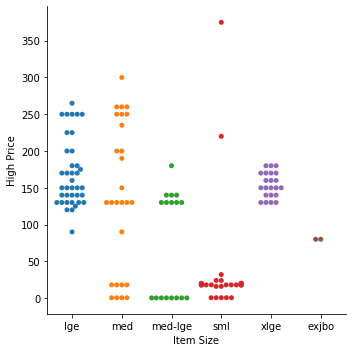

In [8]:
# Factor Plot
g = sns.factorplot(x='Item Size', 
                   y='High Price', 
                   data=dataset, 
                   kind='swarm')
 
# Rotación de la gráfica para fácil visualización
g.set_xticklabels(rotation=0)

#### Ver por qué los medianos están tan bajos
Se va a consultar el dataset para ver qué características presentan los datos con precio bajo y tamaño mediano

In [9]:
dataset[(dataset['Item Size'] =='med') & (dataset['High Price'] <= 50)].head(10)

,High Price,Item Size,Package,Unit of Sale
21,0.5,med,36 inch bins,PER LB
22,0.5,med,36 inch bins,PER LB
23,0.5,med,36 inch bins,PER LB
25,0.5,med,36 inch bins,PER LB
41,18.0,med,1 1/9 bushel cartons,NaN
99,18.0,med,1 1/9 bushel crates,NaN
108,18.0,med,1 1/9 bushel crates,NaN
110,18.0,med,1 1/9 bushel crates,NaN


##### Comentario Juandieguístico
Es porque los precios están dados en lb. Podemos estandarizarlos a BINS

## Conversión numérica
Ahora simplemente se transformarán las categorías a números, si son 10 categorías serán números comprendidos entre 0 y 9 o 1 y 10.

In [10]:
# Primero se convierte la categoría en tipo Categorical
dataset['Item Size'] = pd.Categorical(dataset['Item Size'])
dataset_number = dataset

Lo que se hará es respetar la siguiente lista
1. sml
2. med
3. med-lge
4. lge
5. xlge
6. exjbo

In [11]:
# Codificando el dataset
dataset_number['NumberSize'] = 0

In [12]:
dataset.loc[(dataset['Item Size'] =='sml'), 'NumberSize'] = 0
dataset.loc[(dataset['Item Size'] =='med'), 'NumberSize'] = 1
dataset.loc[(dataset['Item Size'] =='med-lge'), 'NumberSize'] = 2
dataset.loc[(dataset['Item Size'] =='lge'), 'NumberSize'] = 3
dataset.loc[(dataset['Item Size'] =='xlge'), 'NumberSize'] = 4
dataset.loc[(dataset['Item Size'] =='exjbo'), 'NumberSize'] = 5

In [13]:
# Eliminando la columna innecesaria
# dataset_number.drop('Item Size',axis = 1, inplace=True)
dataset['NumberSize'] = dataset['NumberSize'].astype('int64')
dataset['High Price'] = dataset['High Price'].astype('int64')
dataset_number

,High Price,Item Size,Package,Unit of Sale,NumberSize
0,130,lge,24 inch bins,PER BIN,3
1,130,med,24 inch bins,PER BIN,1
2,130,lge,24 inch bins,PER BIN,3
3,130,med,24 inch bins,PER BIN,1
4,130,lge,24 inch bins,PER BIN,3
...,...,...,...,...,...
107,32,sml,bushel cartons,NaN,0
108,18,med,1 1/9 bushel crates,NaN,1
109,18,sml,1 1/9 bushel crates,NaN,0
110,18,med,1 1/9 bushel crates,NaN,1


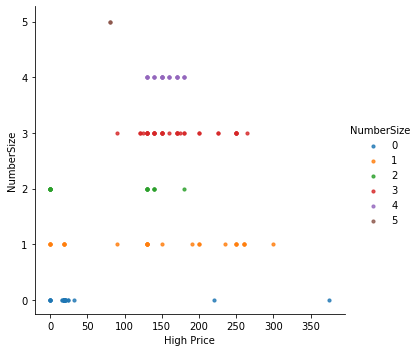

In [14]:
sns.lmplot( y="NumberSize", x="High Price",
  data=dataset, 
  fit_reg=False, 
  hue='NumberSize', # color by cluster
  legend=True,
  scatter_kws={"s": 10}) # specify the point size
plt.show()

## Convirtiendo y estandarizando precios
Como se nota, no todos los productos están bajo la misma medida, existen variaciones en Unit of Sale, por lo que los precios son rarísimos. Por lo que se investigó más a detalle el mercado de las calabazas y sus unidades de medida y venta.

Aquí hay algunas [tablas de conversión](https://www.nass.usda.gov/Statistics_by_State/Delaware/Publications/Annual_Statistical_Bulletin/2009/Page29.pdf).
[Información sobre calabazas](http://www.danschantz.com/fall/pumpkins/)
[Tabla de conversión](https://books.google.com.gt/books?id=xk8qAAAAYAAJ&pg=PA76&lpg=PA76&dq=bushel+to+pounds+pumpkin&source=bl&ots=i1CjFx2JkU&sig=ACfU3U3vL3CO9jeFxPsDFCZePnqy_ycBrg&hl=es-419&sa=X&ved=2ahUKEwj4nefX99PnAhWOxVkKHeUgAeI4ChDoATAAegQIChAB#v=onepage&q=bushel%20to%20pounds%20pumpkin&f=false)

Por el momento, lo importante es desaparecer la ambigüedad existente entre **bin** y **lbs** y la relación es de 1 *bin* = 1000 *lbs*

Por el momento, lo importante es desaparecer la ambigüedad existente entre **bushel** y **lbs** y la relación es de 1 *bushel* = 25 *lbs*


In [15]:
# Valores por lb deben de multiplicarse por 1000
# Obteniendo los valores
dataset.loc[(dataset['Unit of Sale'] =='PER LB'), 'High Price'] *= 1000
dataset.loc[(dataset['Unit of Sale'] =='PER LB'), 'Unit of Sale'] = 'PER BIN'
dataset[(dataset['Unit of Sale'] =='PER LB')].head() # Ya no hay productos por libra

,High Price,Item Size,Package,Unit of Sale,NumberSize


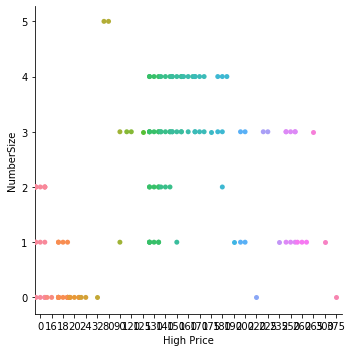

In [16]:
# Factor Plot
g = sns.factorplot(x='High Price', 
                   y='NumberSize', 
                   data=dataset, 
                   kind='swarm')
 
# Rotación de la gráfica para fácil visualización
g.set_xticklabels(rotation=0)

In [17]:
# Valores por 1 1/9 deben de multiplicarse por 25*10/9
# Obteniendo los valores
dataset.loc[(dataset['Package'] =='1 1/9 bushel cartons'), 'High Price'] *= (250/9)
dataset.loc[(dataset['Package'] =='1 1/9 bushel cartons'), 'Package'] = '36 inch bins'
dataset[(dataset['Package'] =='1 1/9 bushel cartons')].head()

,High Price,Item Size,Package,Unit of Sale,NumberSize


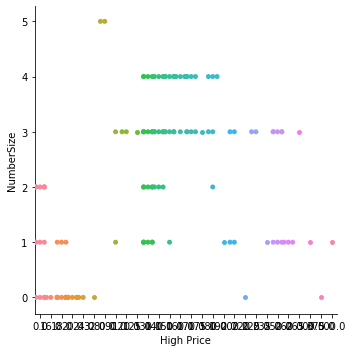

In [18]:
# Factor Plot
g = sns.factorplot(x='High Price', 
                   y='NumberSize', 
                   data=dataset, 
                   kind='swarm')
 
# Rotación de la gráfica para fácil visualización
g.set_xticklabels(rotation=0)

## Función de escalamiento
Sea como sea la gráfica se ve feísima. Aplicaré una estandarización a los datos primero.
\begin{align}
\frac{max_{new}-min_{new}}{max_{old}-min_{old}}\cdot (v-min_{old})+min_{new}
\end{align}

In [19]:
# Función de escalamiento con base al modelo matemático
def rescale(values, new_min = 0, new_max = 100):
    output = []
    old_min, old_max = min(values), max(values)

    for v in values:
        new_v = (new_max - new_min) / (old_max - old_min) * (v - old_min) + new_min
        output.append(new_v)

    return output

In [20]:
dataset['escPrice'] = rescale(dataset.iloc[:,0], 0, 1)
dataset['escPrice'] = dataset['escPrice'].astype('float')
dataset.head(10)

,High Price,Item Size,Package,Unit of Sale,NumberSize,escPrice
0,130.0,lge,24 inch bins,PER BIN,3,0.26
1,130.0,med,24 inch bins,PER BIN,1,0.26
2,130.0,lge,24 inch bins,PER BIN,3,0.26
3,130.0,med,24 inch bins,PER BIN,1,0.26
4,130.0,lge,24 inch bins,PER BIN,3,0.26
5,130.0,med,24 inch bins,PER BIN,1,0.26
6,130.0,lge,24 inch bins,PER BIN,3,0.26
7,130.0,med,24 inch bins,PER BIN,1,0.26
8,130.0,lge,24 inch bins,PER BIN,3,0.26
9,130.0,med,24 inch bins,PER BIN,1,0.26


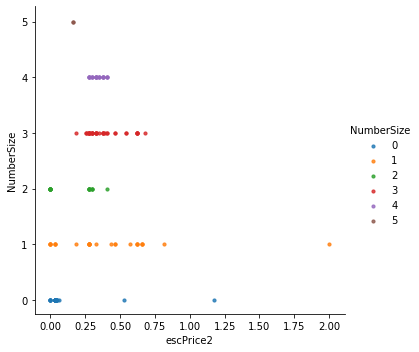

In [21]:
dataset['escPrice2'] = dataset['escPrice']**3 + dataset['escPrice']
# Probando formas de ver la gráfica...
# dataset['escPrice2'] = dataset['escPrice'].astype('float')
# dataset['escPrice2'] = dataset['escPrice'].apply(lambda x: math.log(x))
sns.lmplot( x="escPrice2", y="NumberSize",
  data=dataset, 
  fit_reg=False, 
  hue='NumberSize', # color by cluster
  legend=True,
  scatter_kws={"s": 10}) # specify the point size
plt.show()

## Codificación numérica de categorías
Para tratar las categorías se usarán dos tratamientos, luego se comparará entre ellos cuál es más útil. La primera será una conversión de categoría a números y la segunda será la reconocida "one hot encoding".

### _One hot encoding_
Este sistema consiste en convertir las posibles respuestas en columnas binarias, donde se tiene 1 o 0 si corresponde o no a dicha categoría.

In [22]:
one_hot = pd.get_dummies(dataset['Item Size'])
one_hot.head()

Item Size,exjbo,lge,med,med-lge,sml,xlge
0,0,1,0,0,0,0
1,0,0,1,0,0,0
2,0,1,0,0,0,0
3,0,0,1,0,0,0
4,0,1,0,0,0,0


In [23]:
# Ahora se unirá al dataset 
dataset_one = dataset.drop('Item Size',axis = 1)
dataset_one = dataset_one.join(one_hot)
dataset_one

,High Price,Package,Unit of Sale,NumberSize,escPrice,escPrice2,exjbo,lge,med,med-lge,sml,xlge
0,130.0,24 inch bins,PER BIN,3,0.260,0.277576,0,1,0,0,0,0
0,130.0,24 inch bins,PER BIN,3,0.260,0.277576,0,0,0,0,0,1
0,170.0,36 inch bins,NaN,4,0.340,0.379304,0,1,0,0,0,0
0,170.0,36 inch bins,NaN,4,0.340,0.379304,0,0,0,0,0,1
1,130.0,24 inch bins,PER BIN,1,0.260,0.277576,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
107,32.0,bushel cartons,NaN,0,0.064,0.064262,0,0,0,0,1,0
108,18.0,1 1/9 bushel crates,NaN,1,0.036,0.036047,0,0,1,0,0,0
109,18.0,1 1/9 bushel crates,NaN,0,0.036,0.036047,0,0,0,0,1,0
110,18.0,1 1/9 bushel crates,NaN,1,0.036,0.036047,0,0,1,0,0,0


#### Comentario Juandieguístico...
El one Hot encoding no servirá de nada, puesto que deseamos predecir una variable, no un conjunto de ellas. 
Se hizo como ejercicio de estandarización 

## Algoritmo de regresión lineal
Ahora se presentará el algoritmo de regresión lineal realizado en clase. Su implementación es matricial.

#### Función de regresión
Es la función que determina el valor aproximado a partir de las θ.

In [24]:
def funcion(tetas, x):
    """Realiza la regresión lineal
        multiplicación matricial de x por teta
    """
    return np.dot(x, tetas)

#### Función de costo
Es la función que determina que tan certero es nuestro modelo con sus respectivas θ.

In [25]:
def funcion_costo(tetas, x, y):
    """Realiza la función de costo
        para cualquier parámetro teta
    """
    return (np.sum(np.dot(x, tetas) - y) ** 2) / 2*  len(y)

#### Derivada de la función de costo
Nos retorna el vector gradiente que contiene las derivadas parciales de la función de costo con respecto a cada θ.

In [26]:
def derivada_teta_1(tetas, x, y):
    """Realiza la derivada de la función de costo
        para cualquier parámetro teta
    """
    return np.dot(x.T, np.dot(x, tetas) - y) / len(y)

#### Impresión de resultados
Realizamos una función para la impresión de resultados.

In [27]:
def imprimir_resultados(teta, x, y):
    """Sirve para imprimir la lista de tetas y el costo según
        estos usando como base la función de costo.
    """
    for i in range(len(teta)):
        print("\u03B8{sub} = {value}".format(sub = i + 1, value = teta[i]))
    print("El costo es: {}".format(funcion_costo(teta_gradiente, x, y)))

#### Descenso del gradiente
Implementación en Python del descenso del gradiente.

In [28]:
def descenso_gradiente(tetas, x, y, razon_de_aprendizaje = 0.001, numero_de_iteraciones_maximo = 10000, tolerancia = 0.01, razon_decrecimiento=0.5):
    """Sirve para implementar el descenso del gradiente
        y obtener las tetas que mejor describen la función.
    """
    # variables de flujo del gradiente
    teta_gradiente = tetas.copy()
    converger = True
    # Ciclo del descenso
    while (converger):
        # hacer derivada de funcion
        # moverse en el espacio
        numero_de_iteraciones_maximo -= 1
        teta_temporal = teta_gradiente.copy()
        #print(funcion_costo(teta_temporal, x, y))
        derivadas = derivada_teta_1(teta_temporal, x, y)
        teta_gradiente -= razon_de_aprendizaje * derivadas
        if (np.linalg.norm(derivadas) < tolerancia) or (numero_de_iteraciones_maximo == 0):
            converger = False
    return teta_gradiente

## Creando el numpy array y probando el Descenso del Gradiente a secas
Usando como base el dataset transformado de pandas, crearé el numpy array.

In [29]:
x = dataset['escPrice'].tolist()
y = dataset['NumberSize'].tolist()

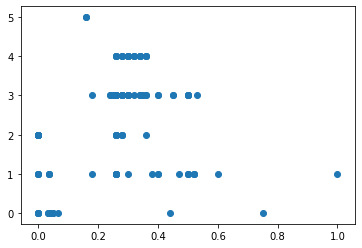

In [30]:
# Graficando nube de puntos
plt.scatter(x, y)

In [31]:
x = [[1 for i in range(len(x))], x]
x = np.array(x, dtype=np.float64)
x = x.T
y = np.array(y)
y = y.T

In [32]:
# Vector de tetas
tetas = [0 for i in range(len(x.T))] # n elementos ya que tenenmos n variables
tetas = np.array(tetas, dtype=np.float64)
tetas = tetas.T
tetas.shape

(2,)

In [33]:
resultado = descenso_gradiente(tetas, x, y, razon_de_aprendizaje = 0.00001, numero_de_iteraciones_maximo=1000000)
funcion_costo(resultado, x, y)

329.9012425395836

In [34]:
resultado # para ver las tetas

array([1.71220337, 1.22987267])

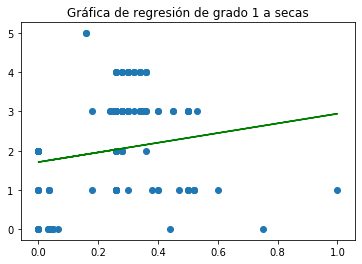

In [35]:
plt.title("Gráfica de regresión de grado 1 a secas")
plt.scatter(x.T[1], y)
plt.plot(x.T[1], np.dot(x, resultado), color='green')

## Cross-Validation
Consiste en hacer un Split 80-10-10 donde se tenga una validación doble de la eficacia del modelo.

In [36]:
# Haciendo el splitting entre training set y test set
train, test = train_test_split(dataset, test_size=0.20) # Usé la librería de sklearn para hacerlo de manera más simple
test, cv = train_test_split(test, test_size=0.50) # Se parte entre CV y test (50 y 50 del 20%)

In [37]:
# El Cross-Validation se ejecutará por grados 
degree = 6 # Número de veces que se ejecuta el CV.
# Haciendo el array de numpy
x = dataset['escPrice'].tolist()
y = dataset['NumberSize'].tolist()

In [38]:
# Construcción de polinomio
def constructor_polinomio(x, grado):
    """Construye columnas en un arreglo respetando el parámetro
        inicial y el grado enviado.
        x, x^2, x^3, x^n
    """
    x_nuevo = [[1 for i in range(len(x))]]
    for i in range(1, grado + 1): # Se le suma 1 porque Python excluye el último número
        x_nuevo.append([j**i for j in x])
    return x_nuevo 

In [39]:
# Medir cuáles valores efectivamente fueron predichos
def precision_del_dataset(tetas, x, y):
    """Mide mediante aproximación si realmente predijo el 
        valor que era. 
    """
    y_pred = np.dot(x, tetas)
    contador = 0
    for i in range(len(y_pred)):
        if(round(y_pred[i]) == y[i]):
            contador += 1
    return contador * 100 / len(y)

In [40]:
# Selector de modelos
def selector_de_modelos(resultados, flag_precision = False, flag_cv = False): # Selecciona el modelo con menor CV
    """Selecciona el mejor modelo de acuerdo a su testing cost.
        Puede priorizar la precisión si se activa la flag, donde
        dará prioridad al modelo con precisión más baja antes que el costo.
    """
    indice = 2
    if flag_precision:
        indice = 3 # Si se prioriza la precisión
    if flag_cv:
        indice += 2 # Si se usa como base CV    
    comodin = resultados[0]
    for i in resultados:
        if(i[indice] < comodin[indice]):
            comodin[indice] = i[indice]
    return comodin        

In [41]:
# Mi implementación de CV
def cross_validation_simple(train, test, cv, degree, razon_de_aprendizaje = 0.0001, numero_de_iteraciones_maximo=1000000):
    """Es una implementación simple de CV donde se almacenan los datos 
        en arreglos distintos y luego se aplcia iterativamente con un grado
        mayor.
    """
    partes = [train, test, cv]
    resultados = []
    for grado in range(1, degree + 1): # se le suma 1 porque Python no es inclusivo 
        resultado = []
        resultados.append([])
        for i in range(len(partes)):
            x = partes[i]['escPrice'].tolist()
            y = partes[i]['NumberSize'].tolist()
            x = constructor_polinomio(x, grado)
            x = np.array(x, dtype=np.float64)
            x = x.T
            y = np.array(y)
            y = y.T
            tetas = [0 for i in range(len(x.T))] # n elementos ya que tenenmos n variables
            tetas = np.array(tetas, dtype=np.float64)
            tetas = tetas.T
            if (i == 0): # training
                resultados[grado - 1].append(grado)
                resultado = descenso_gradiente(tetas, x, y, razon_de_aprendizaje, numero_de_iteraciones_maximo)
                resultados[grado - 1].append(resultado) # Guardamos tetas
            elif (i == 1): # testing
                resultados[grado - 1].append(funcion_costo(resultado, x, y)) 
                resultados[grado - 1].append(precision_del_dataset(resultado, x, y)) 
            else: # CV
                resultados[grado - 1].append(funcion_costo(resultado, x, y))
                resultados[grado - 1].append(precision_del_dataset(resultado, x, y))
    return resultados

In [42]:
# Implementando CV
modelos = cross_validation_simple(train, test, cv, degree)
modelos

[[1,
  array([1.2893746 , 2.71528654]),
  0.07222581503504946,
  21.428571428571427,
  327.1405714306229,
  28.571428571428573],
 [2,
  array([ 1.23823696,  3.66714695, -1.95101552]),
  0.15212913162546604,
  14.285714285714286,
  334.75115785831537,
  28.571428571428573],
 [3,
  array([ 1.16801201,  4.11877434, -1.25747047, -2.39692159]),
  0.8259457075744543,
  21.428571428571427,
  322.73100500238337,
  28.571428571428573],
 [4,
  array([ 1.11732126,  4.27059928, -0.85614815, -1.90555851, -1.82858014]),
  1.0302527937714347,
  28.571428571428573,
  308.37144583997053,
  28.571428571428573],
 [5, array([ 1.09090487,  4.30166652, -0.6486295 , -1.62176879, -1.51184881,
         -1.23538861]), 0.9365459519381067, 28.571428571428573, 298.9881776487558, 28.571428571428573],
 [6, array([ 1.07924812,  4.2924498 , -0.54550148, -1.4644385 , -1.32844323,
         -1.03891442, -0.79635346]), 0.7922615284593724, 28.571428571428573, 294.25106164488807, 28.571428571428573]]

In [43]:
# Seleccionando el modelo ganador
modelo_ganador = selector_de_modelos(modelos)
modelo_ganador

[1,
 array([1.2893746 , 2.71528654]),
 0.07222581503504946,
 21.428571428571427,
 327.1405714306229,
 28.571428571428573]

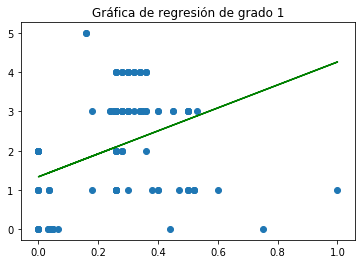

In [234]:
# Graficando nube de puntos y regresión
x = dataset['escPrice'].tolist()
y = dataset['NumberSize'].tolist()
x = constructor_polinomio(x, modelo_ganador[0])
x = np.array(x, dtype=np.float64)
x = x.T
y = np.array(y)
y = y.T
tetas = modelo_ganador[1]
plt.title("Gráfica de regresión de grado {}".format(modelo_ganador[0]))
plt.scatter(x.T[1], y)
plt.plot(x.T[1], np.dot(x, tetas), color='green')